# Project 2: Modeling

## Problem Statement

Build a predictive linear regression model for real estate company to help give the local Ames, Iowa property owner, an idea of how much their home will sell for using features that are easily determinable. 

## Background

Ames, Iowa is a relatively small town of about 66k people. Around half of that population are students. Students make up such a small percentage of home owners that most studies don't seem to collect data on whether they own homes or not. According to the Urban Institute only 37% of people ages 25 - 34 own homes, so it is a safe assumption that homeowners ages 18 - 24 are even fewer. This leaves about half of Ames entire population as potential home buyers. This leaves sellers with fewer options and therefore a smaller margin for error when selling their homes, which is a complicated thing. According to Zillow, 64% of sellers lower their price at least once, which indicates they did not have an accurate expectation of what it should sell for. The longer a house is on the market, the harder it is to sell.

With that in mind it becomse critical to provide Ames with an easy to use tool that would allow for a strong understanding of how much their home will probably sell for. In the following models we aim to achieve the highest possible R2 scores while keeping the base features simple enough for the average homeowner to know.

### Data

* [`test.csv`](../datasets/test.csv): Unseen test data with no price information
* [`train.csv`](../datasets/train.csv): Raw training data to train model on
* [`train_clean.csv`](../datasets/train_clean.csv): The training data cleaned and engineered with new features
* [`kaggle_sub_1.csv`](../datasets/kaggle_sub_1.csv): Predictions for testing data in format for kaggle competition

### Data Dictionary


| Feature          | Type   | Dataset         | Description                                                                                                                                                   |
|------------------|--------|-----------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------|
| ID      | int | train_clean  | Unique home identifier                                                                                                          |
| SalePrice         | int  | train_clean  | Price in USD that each home sold for                                                                                                      |
| Overall Qual        | int  | train_clean  | From the 2019 Us Census, percent of senior class student body racial makeup                                                                                   |
| Total Bsmt SF              | float  | train_clean | Square footage of basement                                                            |
| Gr Liv Area            | int | train_clean        | Square footage of non-basement livable space                                                                     |
| Full Bath    | int  | train_clean        | Number of full bathrooms in home                                                                        |
| TotRms AbvGrd            | in  | train_clean        | Total number of non-basement rooms                                                             |
| Garage Cars            | float  | train_clean        | Number of cars garage can fit                                                             |
| Central Air         | int  | train_clean        | Binary column, 0 if no Central AC, 1 if there is Central AC                                                          |
| Electrical            | object  | train_clean        | Rating the home's electrical grid                                                             |
| Fireplaces        | int    | train_clean      | Number of fireplaces in home |
| Neighborhood          | object  | train_clean      | The name of the neighborhood in Ames, Iowa that home is located                                                                                                                   |
| topqual         | int  | train_clean      | Binary column of whether home is in the top 70th percentile of Overall Quality                                                                                                              |
| price_per_squareft          | float  | train_clean      | Price per square foot of home, unused in model but available if realtor has access to such information                                                                                                              |
| rooms_per_sq_score          | float  | train_clean      | Log of squarefeet over number of rooms                                                                                                                     |
| tophoods          | int  | train_clean      | Ranks 1-4 of the neighborhoods by price point, 4 being most expensive neighborhoods and 1 being the least expensive                                                                                                                     |
| good_elec         | int  | train_clean        | Binary column of whether home's electrical grid is good or not                                                                                                       |
| Heating QC_Fa | int  | train_clean | Dummy column of heat ranking Fair |
| Heating QC_Gd | int  | train_clean | Dummy column of heat ranking Good |
| Heating QC_Po | int  | train_clean | Dummy column of heat ranking Poor |
| Heating QC_TA | int  | train_clean | Dummy column of heat ranking Typical/Average |
| newness | int  | train_clean | Number reflecting the most recent construction event whether it was the house being built or a renovation. Smaller numbers are more recent|



### Data Import

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures

In [3]:
df = pd.read_csv('../datasets/train_clean.csv')


In [4]:
features = ['Overall Qual', 
            'Total Bsmt SF', 
            'Gr Liv Area',
            'Full Bath', 
            'TotRms AbvGrd', 
            'Garage Cars', 
            'Central Air',
            'Fireplaces', 
            'topqual', 
            'rooms_per_sq_score', 
            'tophoods', 
            'good_elec',
            #'Heating QC_Fa', 
            #'Heating QC_Gd', 
            #'Heating QC_Po', 
            #'Heating QC_TA',
            'newness'
           ]

X = df[features]
y= df['SalePrice']

For ease of use by consumer, we left off the Heating scores. If were shooting for a higher model we we reassess their use, potentially binarize between Excellent/Good or not.

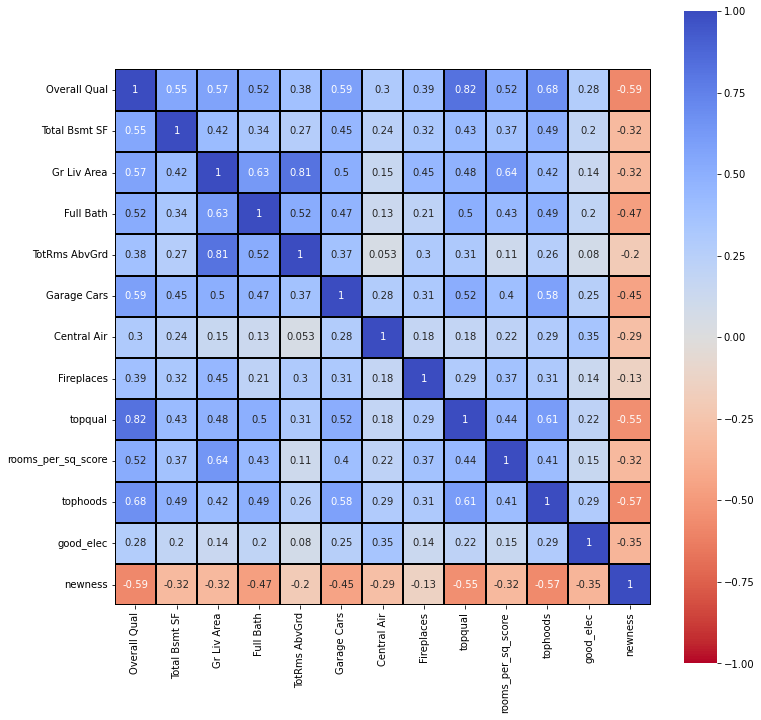

In [5]:
# Heatmap of all features
plt.figure(figsize=(12,12))
sns.heatmap(data=df[features].corr(),annot=True,square=True,cmap='coolwarm_r',vmax=1,vmin=-1,linewidths=1,linecolor='black');

We can see a high correlation leading to some multicollinearity between topqual and Overall Qual, rooms_per_sq_score and Gr Liv Area, and top hoods and quality. To some extent, due to the nature of houses, we have to accept that there will be a certain amount of correlation in our features. I have minimized this in the selected features by choosing and creating features that tell a different story despite their correlation, and therefore improve the predictive model.

For example, tophoods ranks neighborhoods by mean price of houses sold. More expensive houses are generally going to be of a higher quality, so seeing a stronger correlation is to be expected. Having said that, knowing neighborhood and quality together make for a more well-rounded prediction as there are houses that sell for less in good neighborhoods that have lower overall quality.

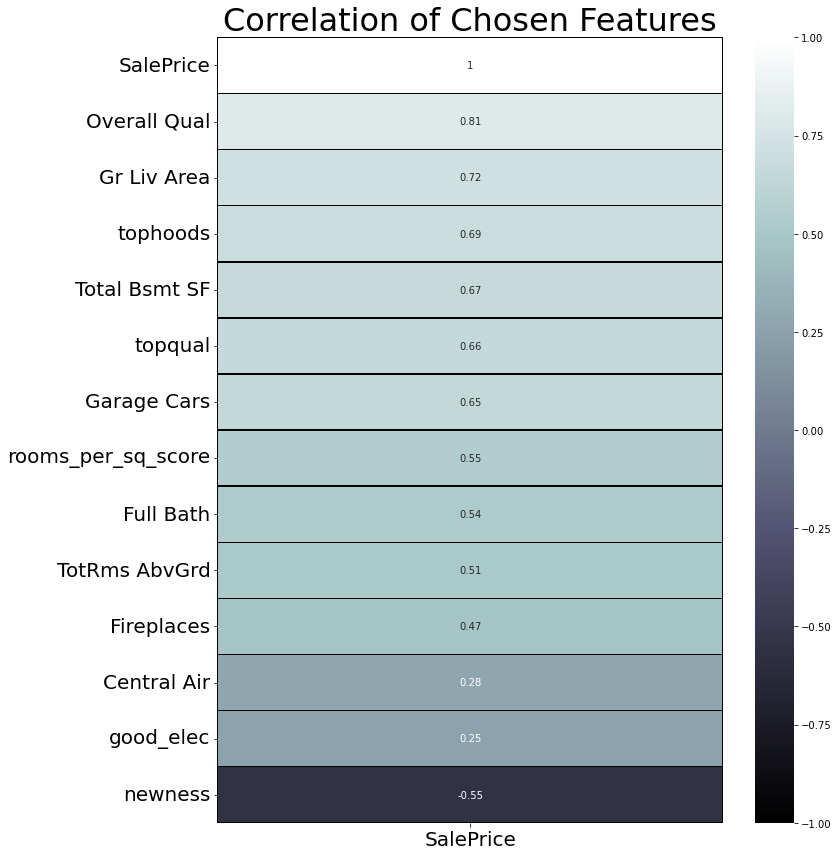

In [6]:
plt.figure(figsize = (12, 12))
sns.heatmap(df.drop(columns={
            'Id',
            'Heating QC_Fa', 
            'Heating QC_Gd', 
            'Heating QC_Po', 
            'Heating QC_TA',
            'price_per_squareft'}).corr()[['SalePrice']].sort_values(by = 'SalePrice',ascending=False),
             annot = True,
             vmin = -1,
             vmax = 1,
             cmap = 'bone',
             linecolor = 'black',linewidths=.5)
plt.title('Correlation of Chosen Features',size=32,color='black');
plt.tick_params(labelsize=20,labelcolor='black')
plt.tight_layout()
#plt.savefig('../imgs/AAfeatures-heatmap.png');

We can see that all chosen features have stong positive correlation to SalePrice except newness, which indidcates that as property gets older and has a longer amount of time between renovations, the less it sells for.

## Base Model

In [7]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.32,
                                                 random_state=42)

In [8]:
lr = LinearRegression()

lr.fit(X_train,y_train)

LinearRegression()

In [9]:
weights = pd.DataFrame({
    'column' : X.columns,
    'coef'   : lr.coef_})
weights
#dfi.export(weights, 'basic_coefs.png')

,column,coef
0,Overall Qual,18488.485744
1,Total Bsmt SF,43.455278
2,Gr Liv Area,172.845515
3,Full Bath,-9363.309129
4,TotRms AbvGrd,-28006.625072
5,Garage Cars,9441.825322
6,Central Air,-6348.402571
7,Fireplaces,6243.821647
8,topqual,-9449.072800
9,rooms_per_sq_score,-171574.816581


All else held equal, we can see that for each one unit rank up in Overall Quality, a house can be expected to sell for $18538.67 more. Alternatively we can see that as the number of rooms increase in a house, the price drops. We can infer that this is due to misused square footage.

In [10]:
# Base Cross val of initial ttsplit
cross_val_score(lr,X_train,y_train).mean(), cross_val_score(lr,X_test,y_test).mean()

(0.8457452128710266, 0.8385930415021233)

In [11]:
#R2 scores
lr.score(X_train,y_train), lr.score(X_test,y_test)

(0.8482778496704447, 0.8432417658662146)

In [12]:
# X_train preds
preds = lr.predict(X_train)

In [13]:
#X_test preds
preds2 = lr.predict(X_test)

In [14]:
# MAE of X_train predictions
metrics.mean_absolute_error(y_train,preds)

21456.021478186554

In [15]:
#MAE of X_test predictions
metrics.mean_absolute_error(y_test,preds2)

21939.021668806774

In [16]:
#RMSE
metrics.mean_squared_error(y_test,preds2,squared=False)

31271.81961192683

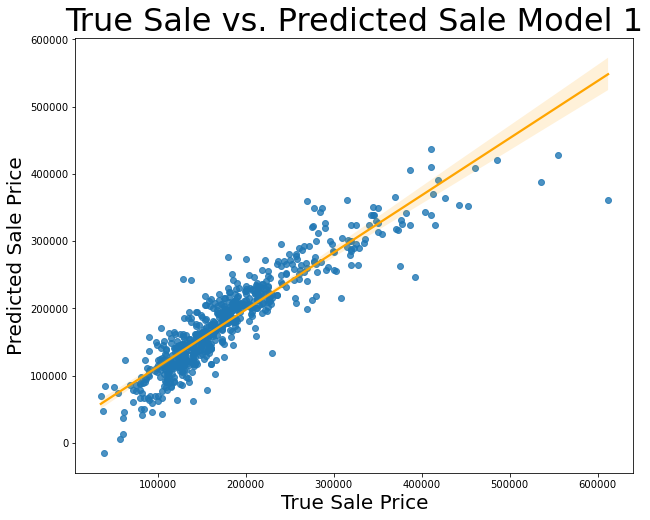

In [17]:
plt.figure(figsize=(10,8))
sns.regplot(x=y_test, y=preds2,line_kws={'color':'orange'});
plt.title('True Sale vs. Predicted Sale Model 1',size=32,color='black')
plt.xlabel('True Sale Price',size=20,color='black')
plt.ylabel('Predicted Sale Price',size=20,color='black');
plt.tick_params(labelcolor='black',)
#plt.savefig('../imgs/black-Model-1.png');

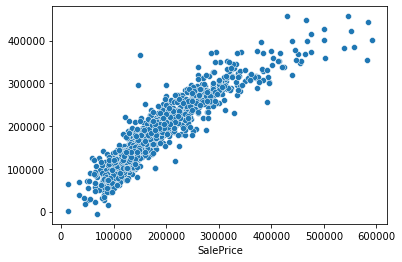

In [18]:
sns.scatterplot(x=y_train,y=preds);

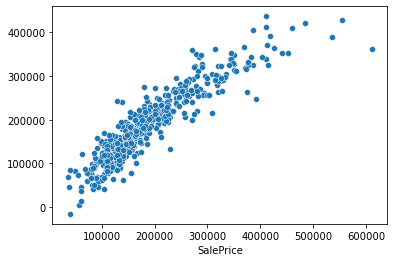

In [19]:
sns.scatterplot(x=y_test,y=preds2);

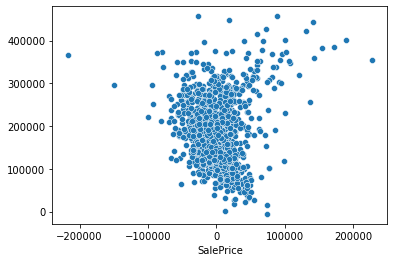

In [20]:
sns.scatterplot(x=y_train-preds,y=preds);

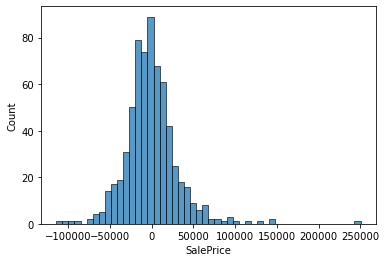

In [21]:
sns.histplot(x=y_test-preds2,);

Checking Line assumptions, they appear to be decent satisfactory although the above scatter plot is not as evenly distributed as we would like.

## Adding Poly

In [22]:
poly = PolynomialFeatures(include_bias=False)

X_train_pf = poly.fit_transform(X_train)


X_test_pf = poly.transform(X_test)

In [23]:
lr_pf = LinearRegression()
lr_pf.fit(X_train_pf, y_train)

LinearRegression()

In [24]:
lr_pf.score(X_train_pf,y_train),lr_pf.score(X_test_pf,y_test)

(0.910295633880778, 0.8964789140441366)

In [25]:
cross_val_score(lr_pf,X_train_pf,y_train).mean(), cross_val_score(lr_pf,X_test_pf,y_test).mean()

(0.8844026451370552, 0.8723463412888423)

In [26]:
preds_pf = lr_pf.predict(X_test_pf)
metrics.mean_squared_error(y_test,preds_pf,squared=False)

25412.791925603684

In [27]:
pd.DataFrame(X_train_pf)

,0,1,2,3,4,5,6,7,8,9,...,94,95,96,97,98,99,100,101,102,103
0,7.0,1373.0,1555.0,2.0,7.0,2.0,1.0,1.0,1.0,5.403321,...,29.195874,16.209962,5.403321,16.209962,9.0,3.0,9.0,1.0,3.0,9.0
1,5.0,1214.0,1214.0,1.0,6.0,2.0,1.0,0.0,0.0,5.309917,...,28.195213,5.309917,5.309917,223.016493,1.0,1.0,42.0,1.0,42.0,1764.0
2,5.0,1057.0,1057.0,1.0,6.0,1.0,1.0,0.0,0.0,5.171431,...,26.743694,5.171431,5.171431,36.200014,1.0,1.0,7.0,1.0,7.0,49.0
3,5.0,1392.0,1392.0,1.0,5.0,2.0,1.0,1.0,0.0,5.629059,...,31.686304,11.258118,5.629059,78.806825,4.0,2.0,28.0,1.0,14.0,196.0
4,6.0,1592.0,1652.0,1.0,6.0,2.0,1.0,1.0,0.0,5.617982,...,31.561727,11.235965,5.617982,89.887720,4.0,2.0,32.0,1.0,16.0,256.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1384,7.0,980.0,1714.0,2.0,7.0,2.0,1.0,1.0,1.0,5.500675,...,30.257425,16.502025,5.500675,121.014849,9.0,3.0,66.0,1.0,22.0,484.0
1385,6.0,1069.0,1069.0,2.0,4.0,2.0,1.0,1.0,0.0,5.588185,...,31.227807,11.176369,5.588185,184.410090,4.0,2.0,66.0,1.0,33.0,1089.0
1386,5.0,1106.0,1190.0,1.0,6.0,2.0,1.0,0.0,0.0,5.289949,...,27.983562,10.579898,5.289949,232.757761,4.0,2.0,88.0,1.0,44.0,1936.0
1387,6.0,516.0,1045.0,1.0,5.0,2.0,1.0,1.0,0.0,5.342334,...,28.540535,10.684669,5.342334,144.243025,4.0,2.0,54.0,1.0,27.0,729.0


In [28]:
#!pip install dataframe-image
#import dataframe_image as dfi
fetties = poly.get_feature_names(X.columns)

poly_weights = pd.DataFrame({
    'column' : fetties,
    'coef'   : lr_pf.coef_})
poly_weights = poly_weights.sort_values(by='coef',ascending=False)
poly_weights
#dfi.export(poly_weights.head(), 'polycoefs_head.png')
#dfi.export(poly_weights.tail(), 'polycoefs_tail.png')

,column,coef
9,rooms_per_sq_score,2.786044e+06
4,TotRms AbvGrd,8.004270e+05
5,Garage Cars,3.897975e+05
90,topqual rooms_per_sq_score,1.703685e+05
6,Central Air,1.385481e+05
...,...,...
101,good_elec^2,-1.757559e+05
94,rooms_per_sq_score^2,-2.299210e+05
7,Fireplaces,-4.923479e+05
89,topqual^2,-4.970164e+05


A quick look at our numberous polynomial features indicates many strong coefficients. With more time I would sort through and drop the ones with coefficients that are closer to 0 to see how that affects my RMSE score, hopefully dropping it.

In [29]:
#poly_weights.sort_values(by='coef',ascending=False).tail(100)

In [163]:
columns={
'Overall Qual Total Bsmt SF',
'newness^2',
'Total Bsmt SF Heating QC_TA',
'Gr Liv Area tophoods',
'Total Bsmt SF Garage Cars',
'Total Bsmt SF tophoods',
'Total Bsmt SF Fireplaces',
'Total Bsmt SF Gr Liv Area',
'Total Bsmt SF^2',
'Gr Liv Area^2',
'Total Bsmt SF newness',
'Gr Liv Area newness',
'Total Bsmt SF good_elec',
'Total Bsmt SF topqual',
'Total Bsmt SF Full Bath',
'Total Bsmt SF TotRms AbvGrd'}

The 16 lowest coefficients of the new model with polynomial features.

## Kaggle submission

Prepping and creating csv for kaggle submission prior to scaling and regularization.

In [114]:
def clean_test_data(df):
    
    """Enter untouched test data and apply data cleaning and featur engineering as per training data."""
    
    df_clean = df[['Id','Overall Qual', 'Exter Qual', 'Year Built',
               'Year Remod/Add', 'Yr Sold', 'Gr Liv Area','Total Bsmt SF', 'Full Bath', 'TotRms AbvGrd',
               'Garage Cars','Heating QC', 'Central Air',
               'Electrical','Fireplaces', 'Neighborhood']]
    
    #df_clean = df_clean.loc[df_clean['Gr Liv Area']<3819]
    df_clean = df_clean.loc[df_clean['Garage Cars'] < 5]
    df_clean['topqual'] = df_clean['Overall Qual'] >= 7
    df_clean['topqual'] = df_clean['topqual'].astype(int)
    df_clean['rooms_per_sq_score'] = np.log(df_clean['Gr Liv Area'] / df_clean['TotRms AbvGrd'])
    df_clean['tophoods'] = df_clean['Neighborhood'].map({'StoneBr':4,'NridgHt':4,'NoRidge':4,'GrnHill':4,'Veenker':4,'Timber':4,'Somerst':4,
                                                     'ClearCr':3,'Crawfor':3,'CollgCr':3,'Blmngtn':3,'NWAmes':3,'Gilbert':3,'Greens':3,
                                                    'SawyerW':2,'Mitchel':2,'NAmes':2,'Blueste':2,'NPkVill':2,'Sawyer':2,'Landmrk':2,
                                                    'SWISU':1,'Edwards':1,'BrkSide':1,'OldTown':1,'BrDale':1,'IDOTRR':1,'MeadowV':1})
    df_clean['Central Air'] = df_clean['Central Air'].map({'Y':1,'N':0})
    df_clean['good_elec'] = df_clean['Electrical'].map({'SBrkr':1,'FuseF':0,'FuseA':0, 'FuseP':0, 'Mix':0})
    df_clean = pd.get_dummies(df_clean, columns = ['Heating QC'],drop_first=True)
    df_clean['newness'] = np.where(df_clean['Year Remod/Add'] > df_clean['Year Built'], 
                               df_clean['Yr Sold'] - df_clean['Year Remod/Add'], 
                               df_clean['Yr Sold'] - df_clean['Year Built'])
    df_clean = df_clean.drop(columns={'Year Built', 'Year Remod/Add', 'Yr Sold','Electrical'})
    df_clean = df_clean.replace(np.nan,1)
    
    return df_clean

In [115]:
df_test = pd.read_csv('../datasets/test.csv')

In [116]:
df_test = clean_test_data(df_test)

In [117]:
df_test.shape

(878, 19)

In [118]:
kaggle_poly = poly.transform(df_test[features])

In [119]:
kaggle_preds = lr_pf.predict(kaggle_poly)

In [120]:
df_test['SalePrice'] = kaggle_preds

In [121]:
df_test[['Id','SalePrice']].to_csv('kaggle_sub_1.csv',index=False)

This is my submission for the kaggle contest. I chose to submit before scaling and checking out other regularized regressions.

## Scaling for Reg

In [30]:
ss = StandardScaler()

Z_train = ss.fit_transform(X_train_pf)
Z_test = ss.transform(X_test_pf)

lr_ss = LinearRegression()

lr_ss.fit(Z_train, y_train)

LinearRegression()

In [31]:
lr_ss.score(Z_train,y_train),lr_ss.score(Z_test,y_test)

(0.9102956338807774, 0.8964789140443777)

In [32]:
cross_val_score(lr_ss,Z_train,y_train).mean(), cross_val_score(lr_ss,Z_test,y_test).mean()

(0.8844026450460925, 0.8723463412358017)

In [33]:
preds_ss = lr_ss.predict(Z_test)

In [34]:
metrics.mean_absolute_error(y_test,preds_ss)

17495.468147485088

In [35]:
metrics.mean_squared_error(y_test,preds_ss,squared=False)

25412.791925574085

Scaling the data and creating new train/test variables in preparation for Ridge/Lasso regressions. Scaled data scores similarly to poly data.

### Import Ridge

In [36]:
from sklearn.linear_model import Ridge, RidgeCV

In [37]:
#find best alpha
r_alphas = np.logspace(0,5,100)

ridge_cv = RidgeCV(alphas = r_alphas, scoring='r2', cv=5)

ridge_cv.fit(Z_train, y_train);

In [38]:
ridge_cv.alpha_

23.101297000831593

In [39]:
predicz = ridge_cv.predict(Z_test)

In [40]:
ridge_cv.score(Z_train, y_train) , ridge_cv.score(Z_test, y_test)

(0.9017324142430421, 0.9029002084700954)

In [41]:
cross_val_score(ridge_cv,Z_train,y_train,).mean(), cross_val_score(ridge_cv,Z_test,y_test,).mean()

(0.891928100615142, 0.8912266163082485)

R2 scores show that not only did that train/test data regularize and lose it's slight overfit, it also increased a little!

In [42]:
metrics.mean_squared_error(y_test,predicz,squared=False)

24612.01208838822

In [43]:
metrics.mean_absolute_error(y_test,predicz)

17190.610890332002

RMSE and MAE decreased. MAE tells us that *about* $17k is the expected error of predicted home prices, which is not too bad. RMSE is higher but is penalizing more than it could because I left in some significant outliers. If I were to remove those I predict this score would improve as well.

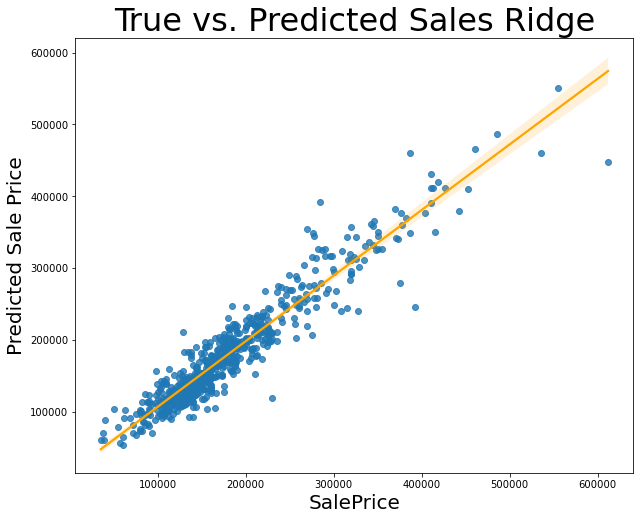

In [44]:
plt.figure(figsize=(10,8))
plt.title('True vs. Predicted Sales Ridge',size=32,color='black')
plt.xlabel('True Sale Price',size=20,color='black')
plt.ylabel('Predicted Sale Price',size=20,color='black');
plt.tick_params(labelcolor='black',)

sns.regplot(x=y_test,y=predicz,line_kws={'color':'orange'});
#plt.savefig('../imgs/black-Model-ridge.png');

Compared with previous model, there is a clear improvement of linearity with this model. We can also see that there is noticable heteroscedasticity, however as this model is geared towards the average Ames user, and the more expensive houses are far from the mean, I believe it is won't lose much efficacy. To imporve the heteroscedasticity, I could potentially take the log, cut down on outliers, and use a more elegant data imputation method than currently in use.

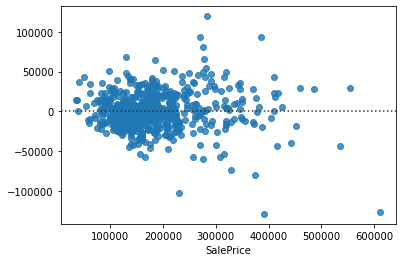

In [147]:
sns.residplot(x=y_test,y=predicz);

Checking some the NE in LINE assumptions for the Ridge Model. Looks pretty good!

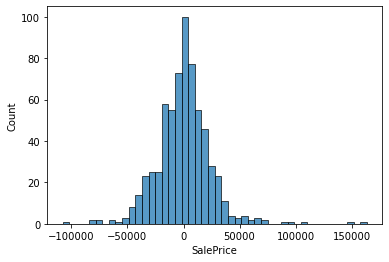

In [206]:
#N
sns.histplot(y_test-predicz);

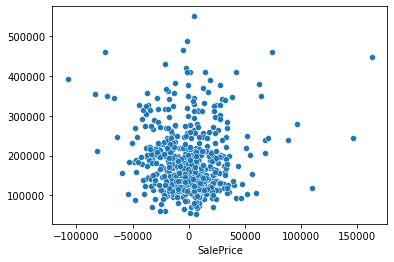

In [211]:
#E
sns.scatterplot(x=y_test-predicz,y=predicz);

### Lasso

In [47]:
from sklearn.linear_model import Lasso, LassoCV

In [48]:
y_test.shape

(655,)

In [49]:
#WARNING may take a while to run
l_alphas = np.logspace(0,5,100)

lasso_cv = LassoCV(alphas=l_alphas, cv=5, n_jobs=2, max_iter=500_000,tol=.01)

lasso_cv.fit(Z_train, y_train);

In [50]:
lasso_cv.alpha_

117.68119524349979

In [51]:
lasso_cv.score(Z_train, y_train), lasso_cv.score(Z_test, y_test)

(0.9007018553029753, 0.9027105166770777)

While this model is also good, it's a little underfit compared to Ridge so will keep Ridge as priamry model.

## Conclusions and Recommendations

We set out to build a Regression model that would, relatively accurately, predict the sales price of homes in Ames, Iowa. We wanted to keep the features of this model simple enough for a homeowner to quickly be able to run without having to make a lot of judgement calls, and outside research on their home.  

In this we have succeeded. We tried a few different types of models including unscaled MLR, Ridge, Lasso, with multiple iterations excluding and including Polynomial features as well as our own engineered ones. 

What we found was that our Ridge regression with PolynomialFeatures ran the best. 
It had: 

R2 = .902 or 90%
MAE = 17,190.61
RMSE = 24,612.01

This tells us that we can explain around 90% of the variance in our model with our features. We also know that according to our MAE our predictions our predictions are within 17,190 dollars or by our RMSE  of 24,612 dollars. I believe our RMSE is giving such a hefty penalty due to specific outliers left in the data, as well as the insignificant Poly features left in the model. Removing these and imputing data more elegantly should lower this score. Regardless, being able to predict a price within $25,000 of true value is sufficient for this project.

The Ames, Iowa total population is around 66,427 and 33,391 of those (almost exactly 50%) attend ISU the local university. With student home ownership being so low that data is near impossible to find (only 37% of 25 - 34 year olds own homes), one can imagine that selling a house is no easy feat in Ames and leaves little room for mistakes as the longer a house is on the market, the harder it is to sell. “In fact, according to the Zillow Group Consumer Housing Trends Report, 64 percent of sellers lower their price at least once. The key is to recognize quickly that you’ve overpriced, and make an accurate adjustment,” says Zillow. With this in mind the local average homeowner needs an easily accessible and understood resource for figuring out their home value. This model would be perfect for a local real estate company to use on their website or app that would encourage new clients to utilize their services. It could be something as easy as a questionaire that takes the input data and runs it through our Ridge Regression model. We were able to distill the needed factors from said homeowner into eleven easy questions which require little to no expert knowledge. The questions are as follows: 

|    | Questions                                                                                              |
|-----|--------------------------------------------------------------------------------------------------------|
| 1.  | How many square feet is your basement?                                                                 |
| 2.  | How many square feet is the rest of your home?                                                         |
| 3.  | How many full bathrooms do you have?                                                                   |
| 4.  | How many rooms (excluding basement) do you have?                                                       |
| 5.  | How many cars fit in your garage?                                                                      |
| 6.  | Do you have central A/C?                                                                               |
| 7.  | How many fireplaces do you have?                                                                       |
| 8.  | Do you have a standard circuit breaker?                                                                |
| 9.  | Which Ames neighborhood do you call home?                                                              |
| 10. | When was your most recent major home improvement?                                                      |
| 11. | With all previous questions in mind, how would you rank the overall quality of your home from 1 to 10? |

When continuing work on this model these are some steps that can be taken to improve performance.

1. Check outliers by category and handle appropriately.
2. Finish sorting through Poly features and drop any that have minimal impact or cause issues in model.
3. Use other modeling methods, for example Zillow uses a Neural Network, which could be quite effecitve.
4. Add Kitchen Quality, Foundation variables (note this will trade efficacy for simplicity)

## Citations

- “Ames, Iowa.” Wikipedia, Wikimedia Foundation, 15 Oct. 2021, https://en.wikipedia.org/wiki/Ames,_Iowa. 
- Choi, Jung Hyun, et al. “Millennial Homeownership.” Urban Institute, 11 Mar. 2020, https://www.urban.org/research/publication/millennial-homeownership. 
- “How to Price Your Home to Sell: Zillow.” Home Sellers Guide, 1 Nov. 2021, https://www.zillow.com/sellers-guide/how-to-price-home-to-sell/. 